In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
import pandas as pd

### Assignment Requirement
A popular TCP protocol is the TCP Reno, which uses the Additive-IncreaseMultiplicative-Decrease (AIMD) algorithm to control the amount of data sent. The AIMD algorithm controls the congestion window with two parameters. For source s, let the additive and the multiplicative parameters be set as, respectively, alpha and 0 < beta < 1. Typically, these two additive and the multiplicative parameters are set as 1 and 0.5, and this leads to a trajectory as shown below for two senders over a common switching link. Discuss how you might set the AIMD parameters in a data center environment with its integrated tiered architecture. Will fairness still be important in a data center?

Assignment 1 is Question 3 of Tutorial 1 on the AIMD mechanism of TCP and is Individual Submission by each student (not group work). Please submit a report (not more than five pages) written in Microsoft Word or Latex (https://www.overleaf.com/).
Your report should consist of a section where you explore tuning AIMD parameters. For example, I demonstrated a code with the alpha parameter bring the logarithmic function of window size in the tutorial class. For reference, see https://www.evl.uic.edu/eric/atp/HighSpeedTCP.pdf and consider different functions to design alpha and beta parameters.
Your resport should have a section of numerical examples and experiments with different number of TCP users/flows sharing a single bottleneck. Show that the TCP dynamics converge numerically to some solution (e.g., the right eigenvector of the matrix A in the Lecture slides). Lastly, your report should have discussions based on your numerical experiments and a conclusion (attaching your code as Appendix).
You may write your code in any programming language (we have demonstrated a Matlab/Python code in tutorial). You can use Python Jupyther Notebook and attach it as Code in Appendix or convert into a readable PDF or Word document for upload.  


In [2]:
# simulate congestion probability: 90% of not dropping
def next_packet(cwnd, p=0.1):
    binomial_dist = binom(cwnd, p)
    packets_dropped = binomial_dist.ppf(random.random() )
    if packets_dropped == 0:
        return (packets_dropped, "Transfer")
    else:
        return (packets_dropped, "Dropped")

packet drop rate for highspeed aimd is 9.573768705297681e-06


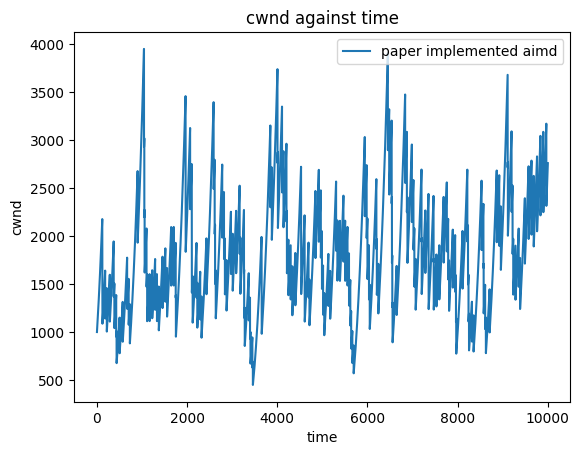

In [3]:
def paper_aimd(rtt_tracker, data_packet, cwnd=10):
    def b(cwnd):
        return (0.1 - 0.5) * (math.log10(cwnd) - math.log10(38)) / (math.log10(83000) - math.log10(38)) + 0.5
    
    _, status = data_packet
    if status == 'Transfer': 
        if (2 - b(cwnd)) > 0:
            a = cwnd**2 * (0.078 / cwnd**1.2) * 2 * b(cwnd) / (2 - b(cwnd))
        cwnd += round(a)

    else:
        cwnd = round(cwnd * (1-b(cwnd)))
        if cwnd<1: cwnd=1
    rtt_tracker.append(cwnd)
    return cwnd


ITERATIONS = 10000
cwnd = 1000
pdr = [0, 0]
rtt_tracker = [cwnd]

# iterate
for i in range(ITERATIONS):
    data_packet = next_packet(cwnd, p=0.00001)
    pdr[0] += cwnd
    pdr[1] += data_packet[0]
    cwnd = paper_aimd(rtt_tracker, data_packet, cwnd=cwnd)

print("packet drop rate for highspeed aimd is", pdr[1]/pdr[0])
    
# visualise
x, y = [], []
for i in range(ITERATIONS):
    x.append(i + 1)
    y.append(rtt_tracker[i])

plt.plot(x, y, label="paper implemented aimd")
plt.xlabel("time")
plt.ylabel("cwnd")
plt.legend()
plt.title(f"cwnd against time")
plt.show()

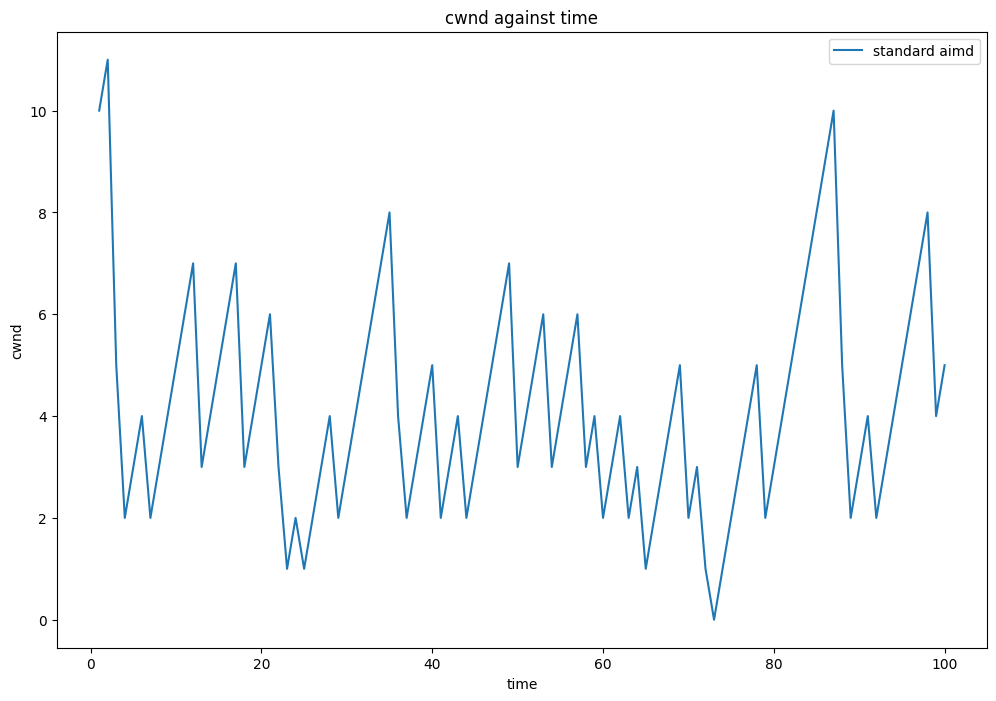

In [4]:
# standard tcp congestion control
def standard_aimd(rtt_tracker, data_packet, cwnd=10, a=1, b=0.5):
    _, status = data_packet
    if status == 'Transfer':
        cwnd += a
    else:
        cwnd = math.floor(cwnd * b)
    rtt_tracker.append(cwnd)
    return cwnd


ITERATIONS = 10000
pdr = []
cwnd_1 = 10
pdr_1 = [0, 0]

rtt_tracker_1 = [cwnd_1]

# iterate
for i in range(ITERATIONS):
    data_packet = next_packet(cwnd_1)
    pdr_1[0] += cwnd_1
    pdr_1[1] += data_packet[0]
    cwnd_1 = standard_aimd(rtt_tracker_1, data_packet, cwnd=cwnd_1)
    
pdr.append(pdr_1)

# visualise
x, y1 = [], []
for i in range(ITERATIONS):
    x.append(i + 1)
    y1.append(rtt_tracker_1[i])

plt.figure(figsize=(12,8))   
plt.plot(x[:100], y1[:100], label="standard aimd")
plt.xlabel("time")
plt.ylabel("cwnd")
plt.legend()
plt.title(f"cwnd against time")
plt.show()

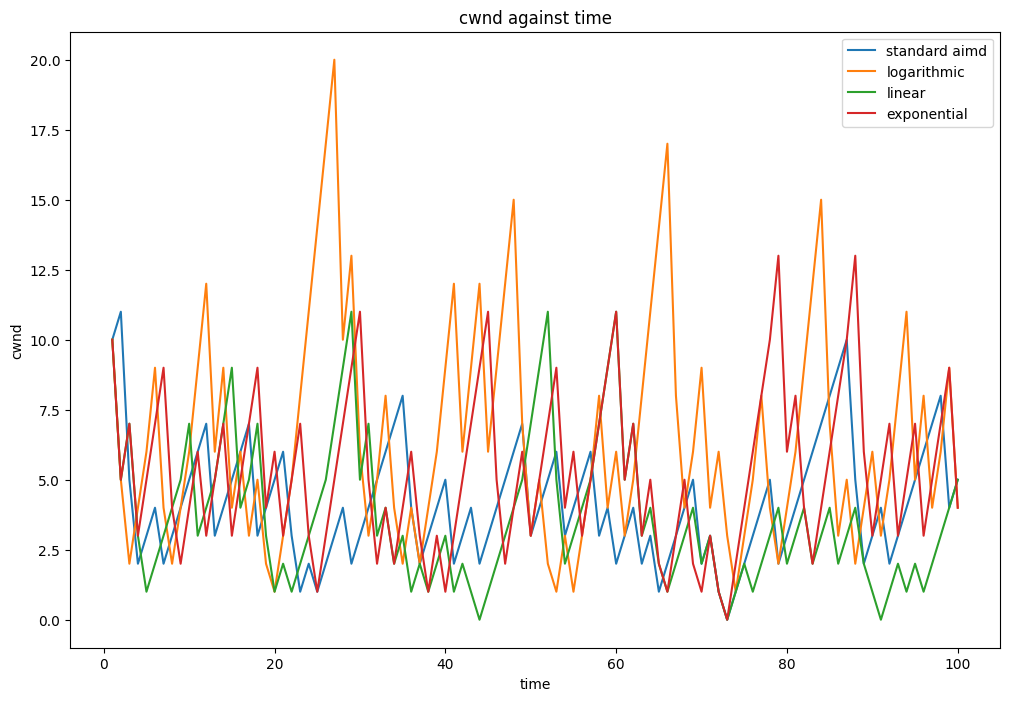

In [5]:
# highspeed tcp as per https://www.evl.uic.edu/eric/atp/HighSpeedTCP.pdf
# w += a(w), a(w) increases with w; (1-b(w))*w, b(w) decreases with w
def ai_logarithmic(rtt_tracker, data_packet, cwnd=10, b=0.5):
    _, status = data_packet
    if status == 'Transfer':
        cwnd += math.ceil(math.log(cwnd+math.e)) # a(w) is a logarithmic function
    else:
        cwnd = math.floor(cwnd * b)
    rtt_tracker.append(cwnd)
    return cwnd


def ai_linear(rtt_tracker, data_packet, cwnd=10, b=0.5, denom=5):
    _, status = data_packet
    if status == 'Transfer': # a(w) is a linear function, mention exponential decay if i want to 
        cwnd += cwnd//denom + 1
    else:
        cwnd = math.floor(cwnd * b)
    rtt_tracker.append(cwnd)
    return cwnd


def ai_exponential(rtt_tracker, data_packet, cwnd=10, b=0.5, lambda_=0.01):
    _, status = data_packet
    if status == 'Transfer': # a(w) is an exponential function
        cwnd += math.floor(math.exp(lambda_*cwnd+1)) 
    else:
        cwnd = math.floor(cwnd * b)
    rtt_tracker.append(cwnd)
    return cwnd


    
cwnd_2 = cwnd_3 = cwnd_4 = 10
pdr_2, pdr_3, pdr_4 = [0, 0], [0, 0], [0, 0]
rtt_tracker_2, rtt_tracker_3, rtt_tracker_4 = [cwnd_2], [cwnd_3], [cwnd_4]


# iterate
for i in range(ITERATIONS):
    data_packet = next_packet(cwnd_2)
    pdr_2[0] += cwnd_2
    pdr_2[1] += data_packet[0]
    cwnd_2 = ai_logarithmic(rtt_tracker_2, data_packet, cwnd=cwnd_2)
    
    data_packet = next_packet(cwnd_3)
    pdr_3[0] += cwnd_3
    pdr_3[1] += data_packet[0]
    cwnd_3 = ai_linear(rtt_tracker_3, data_packet, cwnd=cwnd_3)
    
    data_packet = next_packet(cwnd_4)
    pdr_4[0] += cwnd_4
    pdr_4[1] += data_packet[0]    
    cwnd_4 = ai_exponential(rtt_tracker_4, data_packet, cwnd=cwnd_4)

pdr.extend([pdr_2, pdr_3, pdr_4])

# visualise
y2, y3, y4 = [], [], []
for i in range(ITERATIONS):
    y2.append(rtt_tracker_2[i])
    y3.append(rtt_tracker_3[i])
    y4.append(rtt_tracker_4[i])

plt.figure(figsize=(12,8))   
plt.plot(x[:100], y1[:100], label="standard aimd")
plt.plot(x[:100], y2[:100], label="logarithmic")
plt.plot(x[:100], y3[:100], label="linear")
plt.plot(x[:100], y4[:100], label="exponential")
plt.xlabel("time")
plt.ylabel("cwnd")
plt.legend()
plt.title(f"cwnd against time")
plt.show()

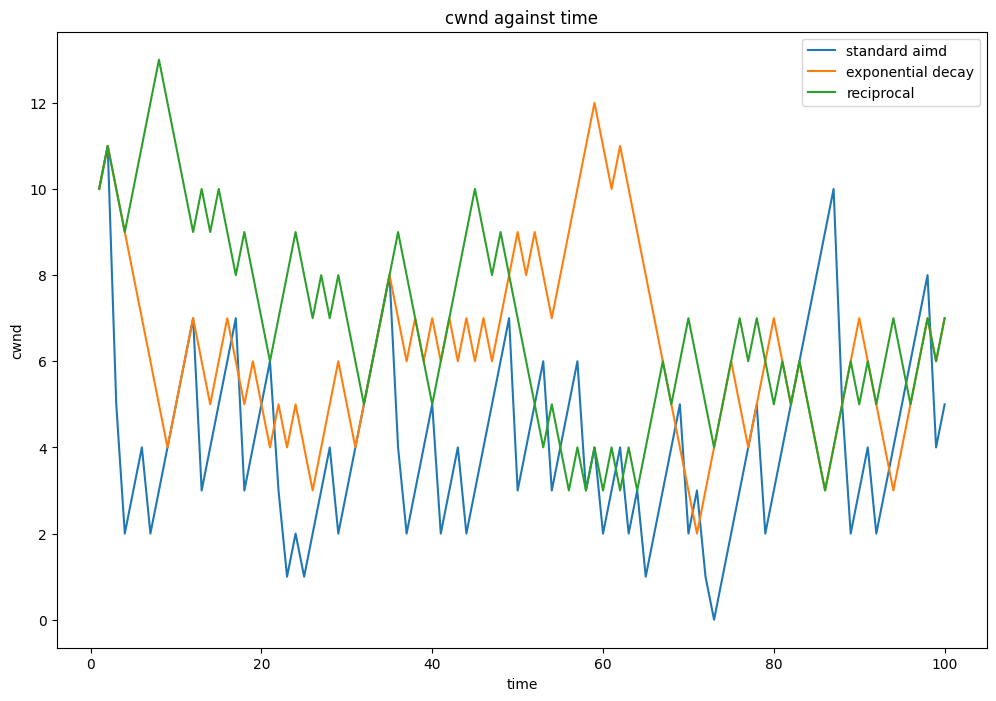

In [6]:
# highspeed tcp as per https://www.evl.uic.edu/eric/atp/HighSpeedTCP.pdf
# w += a(w), a(w) increases with w; (1-b(w))*w, b(w) decreases with w
def md_exponential_decay(rtt_tracker, data_packet, cwnd=10, a=1, lambda_=0.5):
    _, status = data_packet
    if status == 'Transfer':
        cwnd += a
    else:
        cwnd = math.floor(cwnd * (1-math.exp(-lambda_ * cwnd))) # b(w) is an exponential decay function
        if cwnd<1: cwnd=1
    rtt_tracker.append(cwnd)
    return cwnd


def md_reciprocal(rtt_tracker, data_packet, cwnd=10, a=1):
    _, status = data_packet
    if status == 'Transfer': 
        cwnd += a
    else:
        cwnd = math.ceil(cwnd * (1-1/cwnd)) #b(w) is a reciprocal function
    rtt_tracker.append(cwnd)
    return cwnd



    
cwnd_5 = cwnd_6 = 10
pdr_5, pdr_6 = [0, 0], [0, 0]
rtt_tracker_5, rtt_tracker_6 = [cwnd_5], [cwnd_6]


# iterate
for i in range(ITERATIONS):
    data_packet = next_packet(cwnd_5)
    pdr_5[0] += cwnd_5
    pdr_5[1] += data_packet[0]
    cwnd_5 = md_exponential_decay(rtt_tracker_5, data_packet, cwnd=cwnd_5)
    
    data_packet = next_packet(cwnd_6)
    pdr_6[0] += cwnd_6
    pdr_6[1] += data_packet[0]
    cwnd_6 = md_reciprocal(rtt_tracker_6, data_packet, cwnd=cwnd_6)

pdr.extend([pdr_5, pdr_6])
# visualise
y5, y6 = [], []
for i in range(ITERATIONS):
    y5.append(rtt_tracker_5[i])
    y6.append(rtt_tracker_6[i])

plt.figure(figsize=(12,8))   
plt.plot(x[:100], y1[:100], label="standard aimd")
plt.plot(x[:100], y5[:100], label="exponential decay")
plt.plot(x[:100], y6[:100], label="reciprocal")
plt.xlabel("time")
plt.ylabel("cwnd")
plt.legend()
plt.title(f"cwnd against time")
plt.show()

In [7]:
result = {
    "aimd": [
        "standard", 
        "ai_logarithmic", 
        "ai_linear", 
        "ai_exponential",
        "md_exponential_decay",
        "md_reciprocal",
    ],
    
    "total_packets_dropped": [x[1] for x in pdr],
    "total_cwnd": [x[0] for x in pdr]
}
result = pd.DataFrame(result)
result["packet_drop_rate"] = result["total_packets_dropped"]/result["total_cwnd"]
result["avg_cwnd"] = result["total_cwnd"]/ITERATIONS
result

,aimd,total_packets_dropped,total_cwnd,packet_drop_rate,avg_cwnd
0,standard,3499.0,35057,0.099809,3.5057
1,ai_logarithmic,5308.0,52705,0.100712,5.2705
2,ai_linear,3721.0,37051,0.100429,3.7051
3,ai_exponential,4947.0,49185,0.100579,4.9185
4,md_exponential_decay,6836.0,68606,0.099641,6.8606
5,md_reciprocal,6844.0,68416,0.100035,6.8416


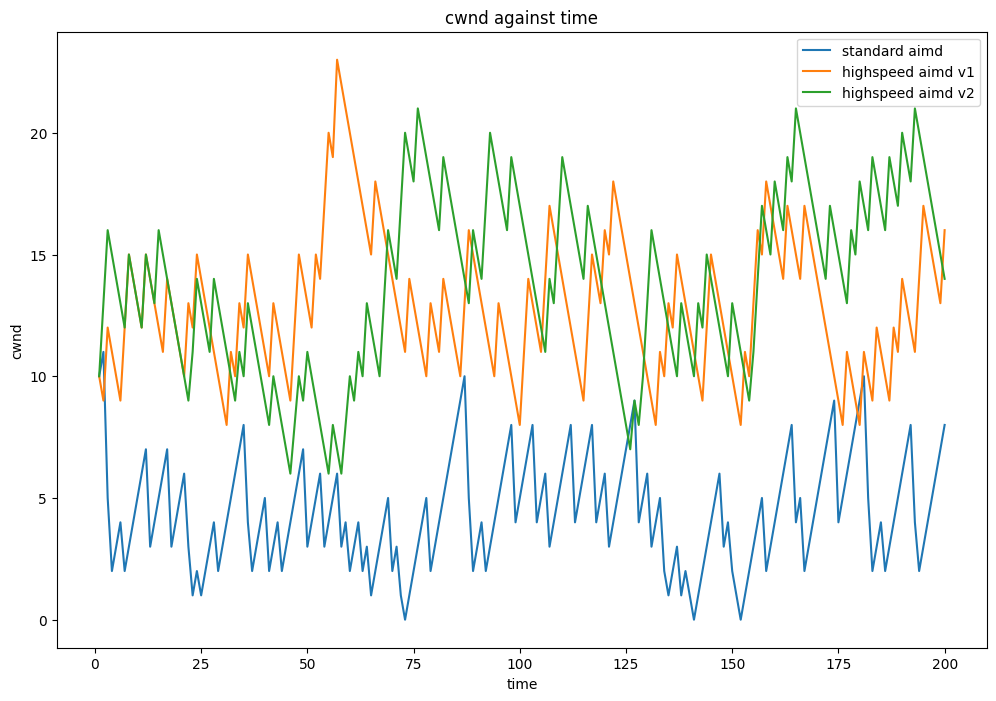

In [8]:
# highspeed tcp as per https://www.evl.uic.edu/eric/atp/HighSpeedTCP.pdf
# w += a(w), a(w) increases with w; (1-b(w))*w, b(w) decreases with w
def highspeed_aimd_v1(rtt_tracker, data_packet, cwnd=10, lambda_=0.5):
    """
    a(w): logarithmic
    b(w): exponential decay
    """
    _, status = data_packet
    if status == 'Transfer':
            cwnd += math.ceil(math.log(cwnd+math.e)) # a(w) is a logarithmic function
    else:
        cwnd = math.floor(cwnd * (1-math.exp(-lambda_ * cwnd))) # b(w) is an exponential decay function
        if cwnd<1: cwnd=1
    rtt_tracker.append(cwnd)
    return cwnd


def highspeed_aimd_v2(rtt_tracker, data_packet, cwnd=10, lambda_=0.01):
    """
    a(w): exponential
    b(w): reciprocal
    """
    _, status = data_packet
    if status == 'Transfer': 
        cwnd += math.floor(math.exp(lambda_*cwnd+1)) 
    else:
        cwnd = math.ceil(cwnd * (1-1/cwnd)) 
    rtt_tracker.append(cwnd)
    return cwnd


    
cwnd_7 = cwnd_8 = 10
pdr_7, pdr_8 = [0, 0], [0, 0]
rtt_tracker_7, rtt_tracker_8 = [cwnd_7], [cwnd_8]

# iterate
for i in range(ITERATIONS):
    data_packet = next_packet(cwnd_7)
    pdr_7[0] += cwnd_7
    pdr_7[1] += data_packet[0]
    cwnd_7 = highspeed_aimd_v1(rtt_tracker_7, data_packet, cwnd=cwnd_7)
    
    data_packet = next_packet(cwnd_8)
    pdr_8[0] += cwnd_8
    pdr_8[1] += data_packet[0]    
    cwnd_8 = highspeed_aimd_v2(rtt_tracker_8, data_packet, cwnd=cwnd_8)
    
    
pdr.extend([pdr_7, pdr_8])    
    
# visualise
y7, y8 = [], []
for i in range(ITERATIONS):
    y7.append(rtt_tracker_7[i])
    y8.append(rtt_tracker_8[i])

plt.figure(figsize=(12,8))   
plt.plot(x[:200], y1[:200], label="standard aimd")
plt.plot(x[:200], y7[:200], label="highspeed aimd v1")
plt.plot(x[:200], y8[:200], label="highspeed aimd v2")
plt.xlabel("time")
plt.ylabel("cwnd")
plt.legend()
plt.title(f"cwnd against time")
plt.show()

In [9]:
result = {
    "aimd": [
        "standard", 
        "ai_logarithmic", 
        "ai_linear", 
        "ai_exponential",
        "md_exponential_decay",
        "md_reciprocal",
        "highspeed_aimd_v1",
        "highspeed_aimd_v2"
    ],
    
    "total_packets_dropped": [x[1] for x in pdr],
    "total_cwnd": [x[0] for x in pdr]
}
result = pd.DataFrame(result)
result["packet_drop_rate"] = result["total_packets_dropped"]/result["total_cwnd"]
result["avg_cwnd"] = result["total_cwnd"]/ITERATIONS
result

,aimd,total_packets_dropped,total_cwnd,packet_drop_rate,avg_cwnd
0,standard,3499.0,35057,0.099809,3.5057
1,ai_logarithmic,5308.0,52705,0.100712,5.2705
2,ai_linear,3721.0,37051,0.100429,3.7051
3,ai_exponential,4947.0,49185,0.100579,4.9185
4,md_exponential_decay,6836.0,68606,0.099641,6.8606
5,md_reciprocal,6844.0,68416,0.100035,6.8416
6,highspeed_aimd_v1,13982.0,140007,0.099866,14.0007
7,highspeed_aimd_v2,13175.0,131454,0.100225,13.1454


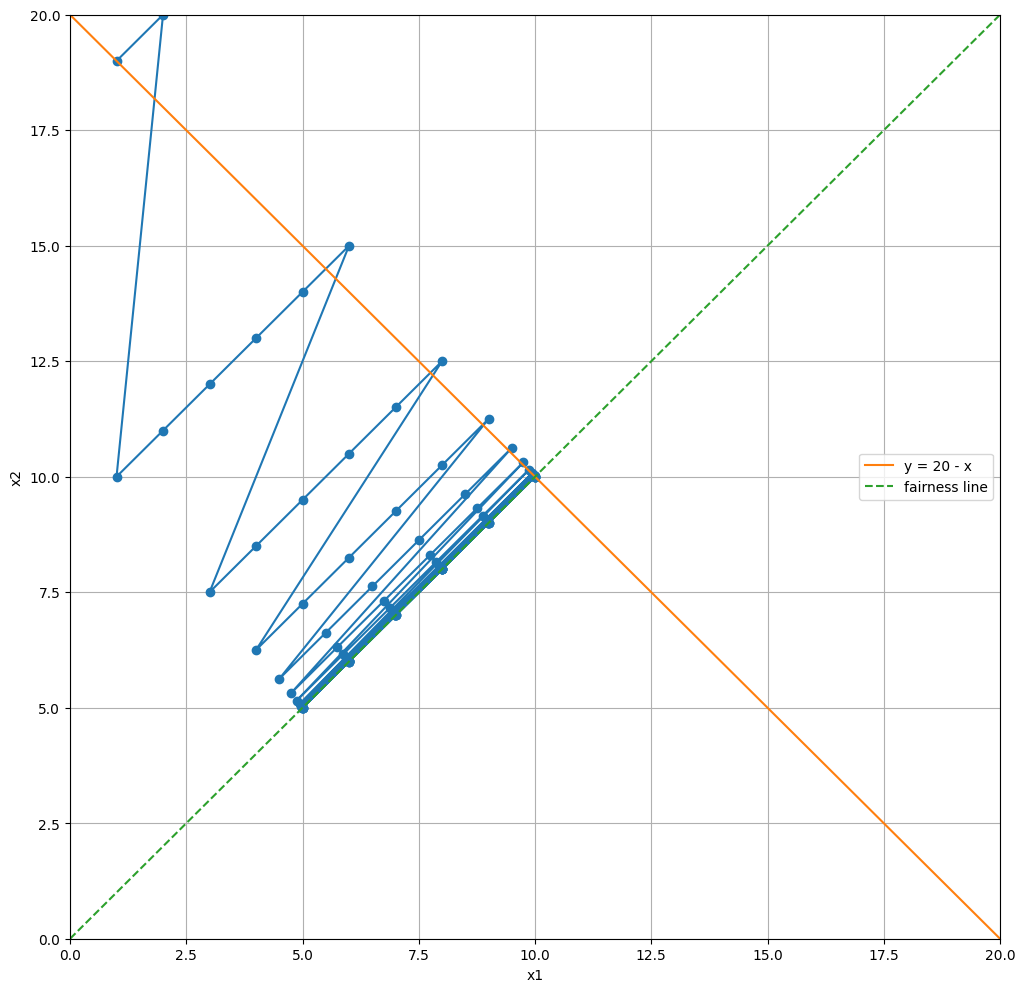

In [10]:
ITERATESMAX = 100 
C = 20
alpha = 1
beta = 0.5
x1 = 1
x2 = 19
x1_values = np.zeros(ITERATESMAX)
x2_values = np.zeros(ITERATESMAX)
for i in range(ITERATESMAX):
    x1_values[i] = x1
    x2_values[i] = x2
    if (x1 + x2 <= C):
        x1 += alpha
        x2 += alpha
    else:
        x1 *= beta
        x2 *= beta

plt.figure(figsize=(12,12))
plt.plot(x1_values, x2_values, marker='o', linestyle='-')
plt.xlabel('x1')
plt.ylabel('x2')
x = np.linspace(0, C, 100) 
y = C - x # capacity
y2 = x # fairness line
plt.plot(x, y, label=f'y = {C} - x')
plt.plot(x, y2, linestyle="--", label='fairness line')
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.legend()
plt.show()

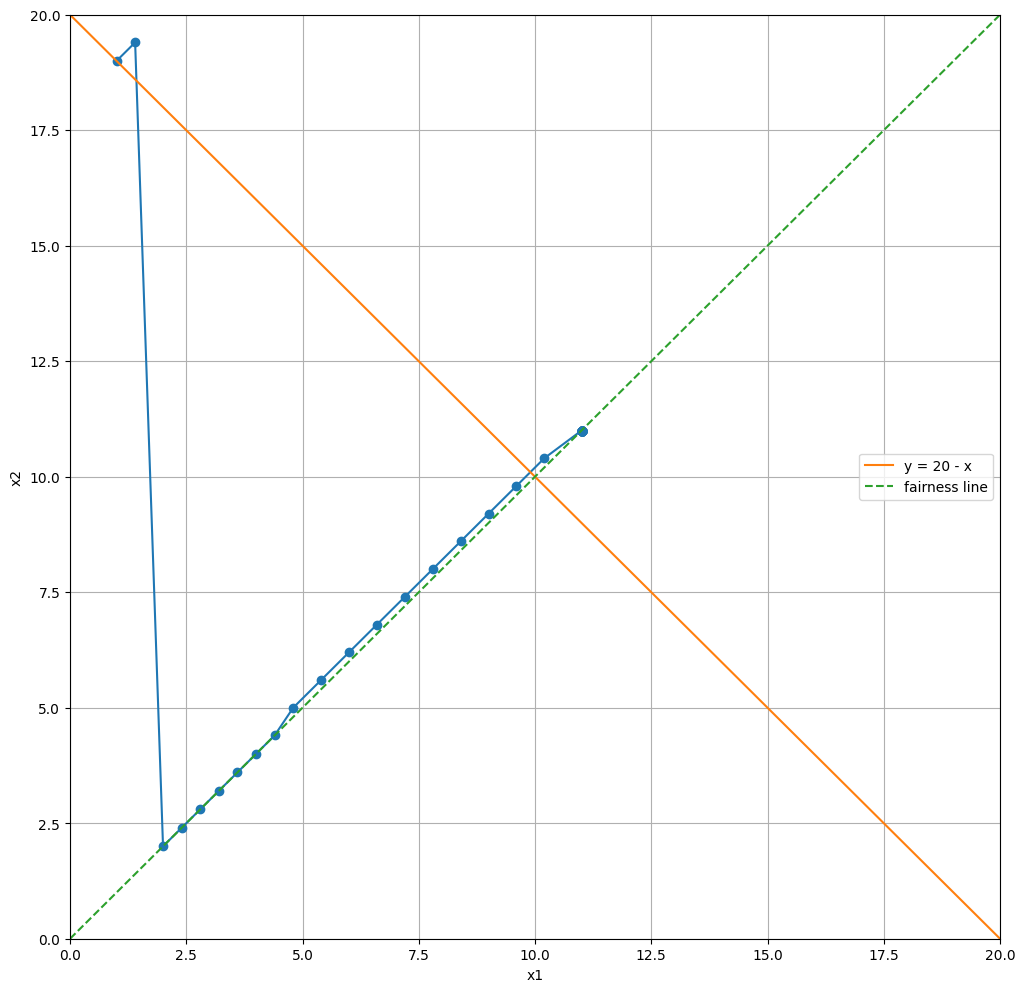

In [11]:
ITERATESMAX = 100 
C = 20
alpha = 0.2 
lambda_ = 0.01
beta = 2
x1 = 1
x2 = 19
x1_values = np.zeros(ITERATESMAX)
x2_values = np.zeros(ITERATESMAX)
for i in range(ITERATESMAX):
    x1_values[i] = x1
    x2_values[i] = x2
    if (x1 + x2 <= C):
        x1 += alpha*math.ceil(math.log(x1+math.e))
        x2 += alpha*math.ceil(math.log(x1+math.e))
    else:
        x1 = math.ceil(x1 * (1-math.exp(-beta * x1)))
        x2 = math.ceil(x1 * (1-math.exp(-beta * x1)))

plt.figure(figsize=(12,12))
plt.plot(x1_values, x2_values, marker='o', linestyle='-')
plt.xlabel('x1')
plt.ylabel('x2')
x = np.linspace(0, C, 100) 
y = C - x # capacity
y2 = x # fairness line
plt.plot(x, y, label=f'y = {C} - x')
plt.plot(x, y2, linestyle="--", label='fairness line')
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.legend()
plt.show()

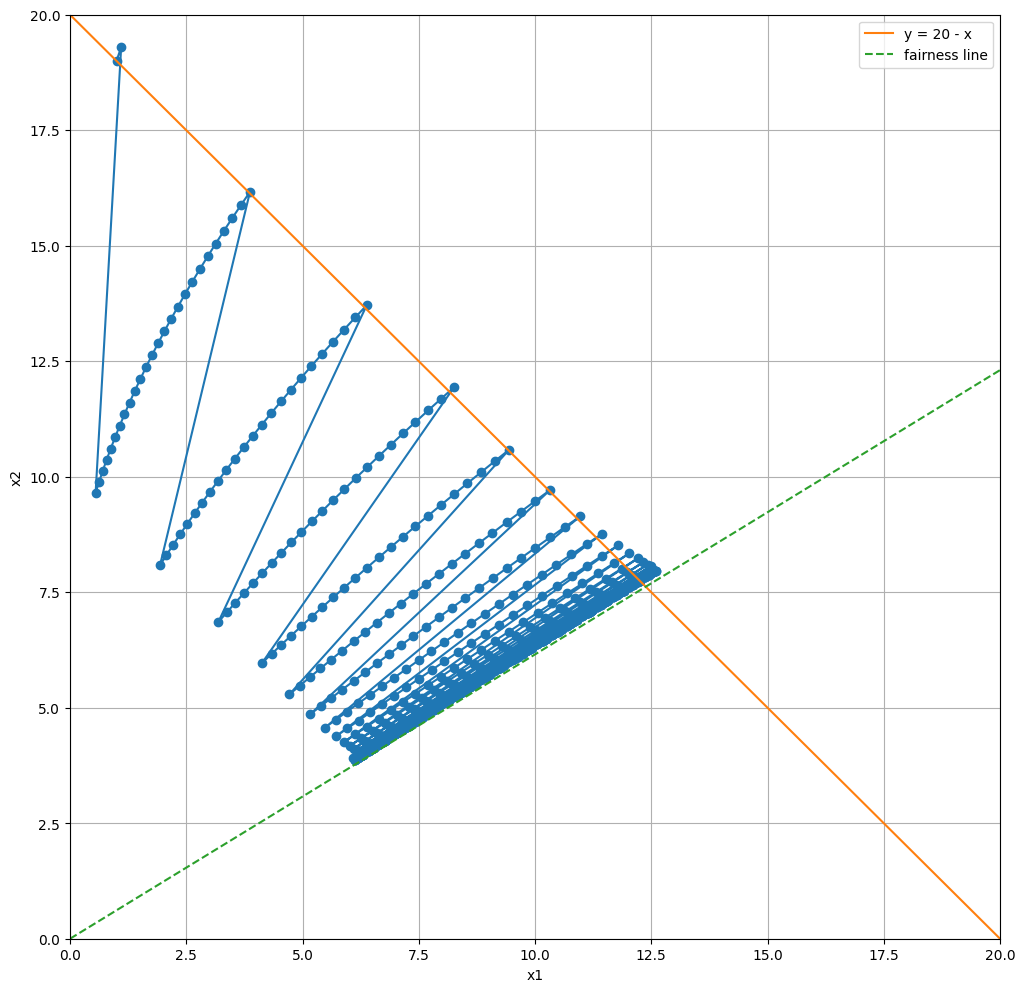

In [12]:
ITERATESMAX = 1000
C = 20 
alpha = 0.1 
beta = 0.5
x1 = 1
x2 = 19
alpha1 = 0
alpha2 = 0
x1_values = np.zeros(ITERATESMAX)
x2_values = np.zeros(ITERATESMAX)
for i in range(ITERATESMAX):
    x1_values[i] = x1
    x2_values[i] = x2
    if (x1 + x2 <= C):
        x1 += alpha * np.power(x1, beta)
        x2 += alpha * np.log(x2 + 1)
    else:
        x1 = x1 * beta
        x2 = x2 * beta


plt.figure(figsize=(12,12))
plt.plot(x1_values, x2_values, marker='o', linestyle='-')
plt.xlabel('x1')
plt.ylabel('x2')
x = np.linspace(0, C, 100) 
y = C - x # capacity
y2 = 8/13*x # fairness line
plt.plot(x, y, label=f'y = {C} - x')
plt.plot(x, y2, linestyle="--", label='fairness line')
plt.grid(True)
plt.xlim(0, C)
plt.ylim(0, C)
plt.legend()
plt.show()

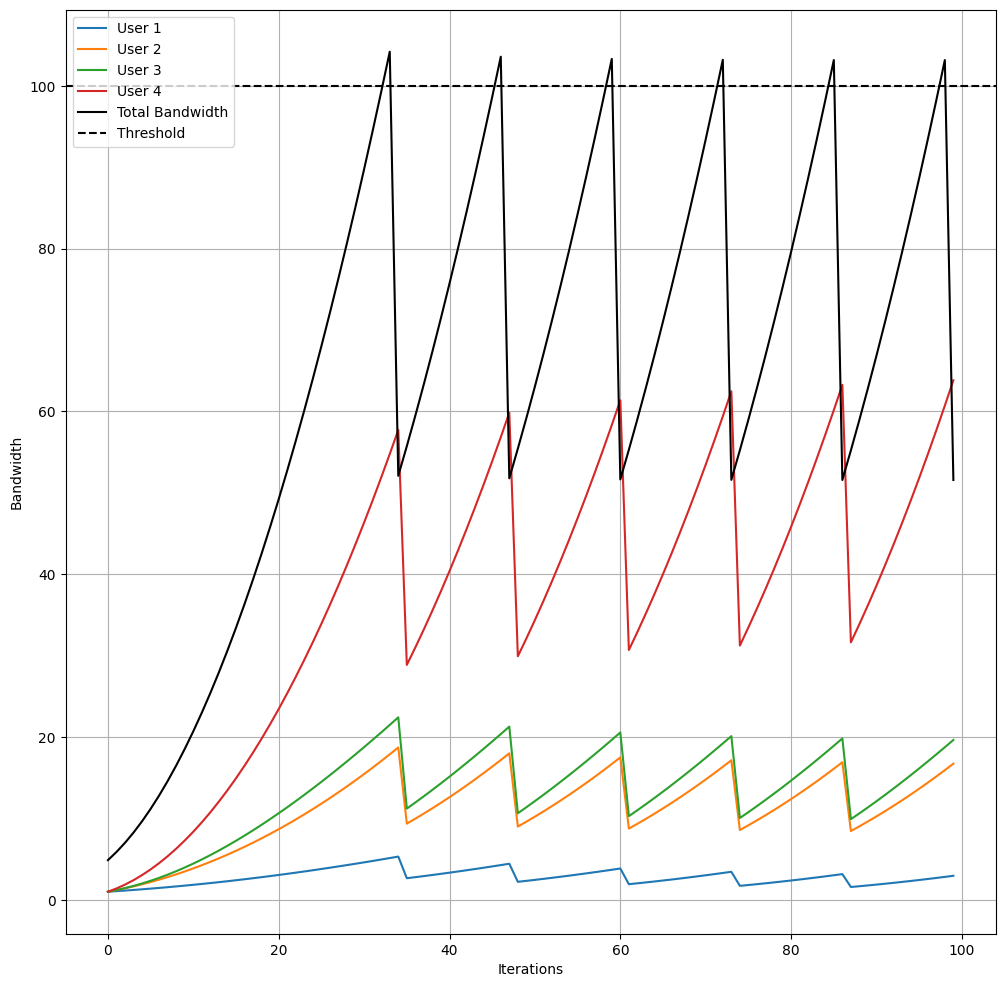

In [13]:
import numpy as np
import matplotlib.pyplot as plt

ITERATESMAX = 100
C = 100
alpha = 0.1
beta = 0.5
n_user = 4  # n_users
exponent1 = 0.5

x_values = np.zeros((ITERATESMAX, n_user))
sum_bandwidth = np.zeros(ITERATESMAX) 
x = np.ones(n_user) # initialisation
for i in range(ITERATESMAX):
    x_values[i] = x

    if np.sum(x) <= C:
        for j in range(n_user):
            if j % 2 == 0:  # Even-numbered users
                x[j] += alpha * (j+1) * np.log(x[j] + 1)
            else:  # Odd-numbered users
                x[j] += alpha * (j+1) * np.power(x[j], exponent1)
    else:
        x *= beta
        
    sum_bandwidth[i] = np.sum(x)

plt.figure(figsize=(12, 12))
for i in range(n_user):
    plt.plot(range(ITERATESMAX), x_values[:, i], linestyle='-', label=f'User {i+1}')

plt.plot(range(ITERATESMAX), sum_bandwidth, linestyle='-', color='black', label='Total Bandwidth')
plt.axhline(y=100, color='black', linestyle='--', label='Threshold')
plt.xlabel('Iterations')
plt.ylabel('Bandwidth')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


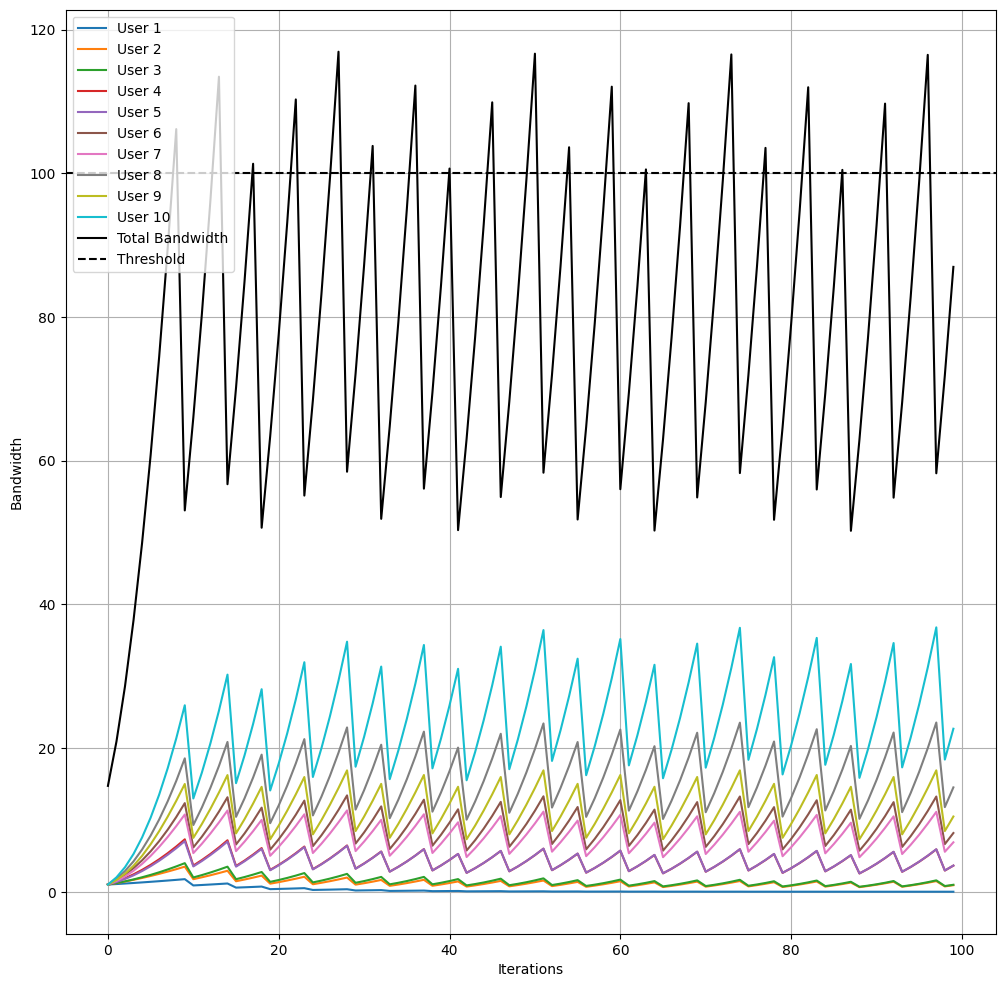

In [14]:
import numpy as np
import matplotlib.pyplot as plt

ITERATESMAX = 100
C = 100
alpha = 0.1
beta = 0.5
n_user = 10  # n_users
exponent1 = 0.5

x_values = np.zeros((ITERATESMAX, n_user))
sum_bandwidth = np.zeros(ITERATESMAX) 
x = np.ones(n_user) # initialisation
for i in range(ITERATESMAX):
    x_values[i] = x

    if np.sum(x) <= C:
        for j in range(n_user):
            if j % 2 == 0:  # Even-numbered users
                x[j] += alpha * (j+1) * np.log(x[j] + 1)
            else:  # Odd-numbered users
                x[j] += alpha * (j+1) * np.power(x[j], exponent1)
    else:
        x *= beta
        
    sum_bandwidth[i] = np.sum(x)

plt.figure(figsize=(12, 12))
for i in range(n_user):
    plt.plot(range(ITERATESMAX), x_values[:, i], linestyle='-', label=f'User {i+1}')

plt.plot(range(ITERATESMAX), sum_bandwidth, linestyle='-', color='black', label='Total Bandwidth')
plt.axhline(y=100, color='black', linestyle='--', label='Threshold')
plt.xlabel('Iterations')
plt.ylabel('Bandwidth')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()
